In [83]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import json
from matplotlib import pyplot as plt
import seaborn as sns
from decimal import Decimal

def smooth(arr, window):
    return pd.Series(arr).rolling(window, min_periods=1).mean().values

In [84]:
hypers = ['S', 'K', 'log_beta_min', 'loss', 'epochs', 'seed',]

In [85]:
path = Path('../runs/')
runs = []
for p in path.glob("*/config.json"):
    with open(p) as data_file:    
        config = json.load(data_file)
    with open(p.parent / 'metrics.json') as data_file:    
        metrics = json.load(data_file)
    with open(p.parent / 'run.json') as data_file:    
        meta = json.load(data_file)
    
    runs.append({**metrics, **config, **meta})

exps = pd.DataFrame(runs)

In [87]:
# Figure 6

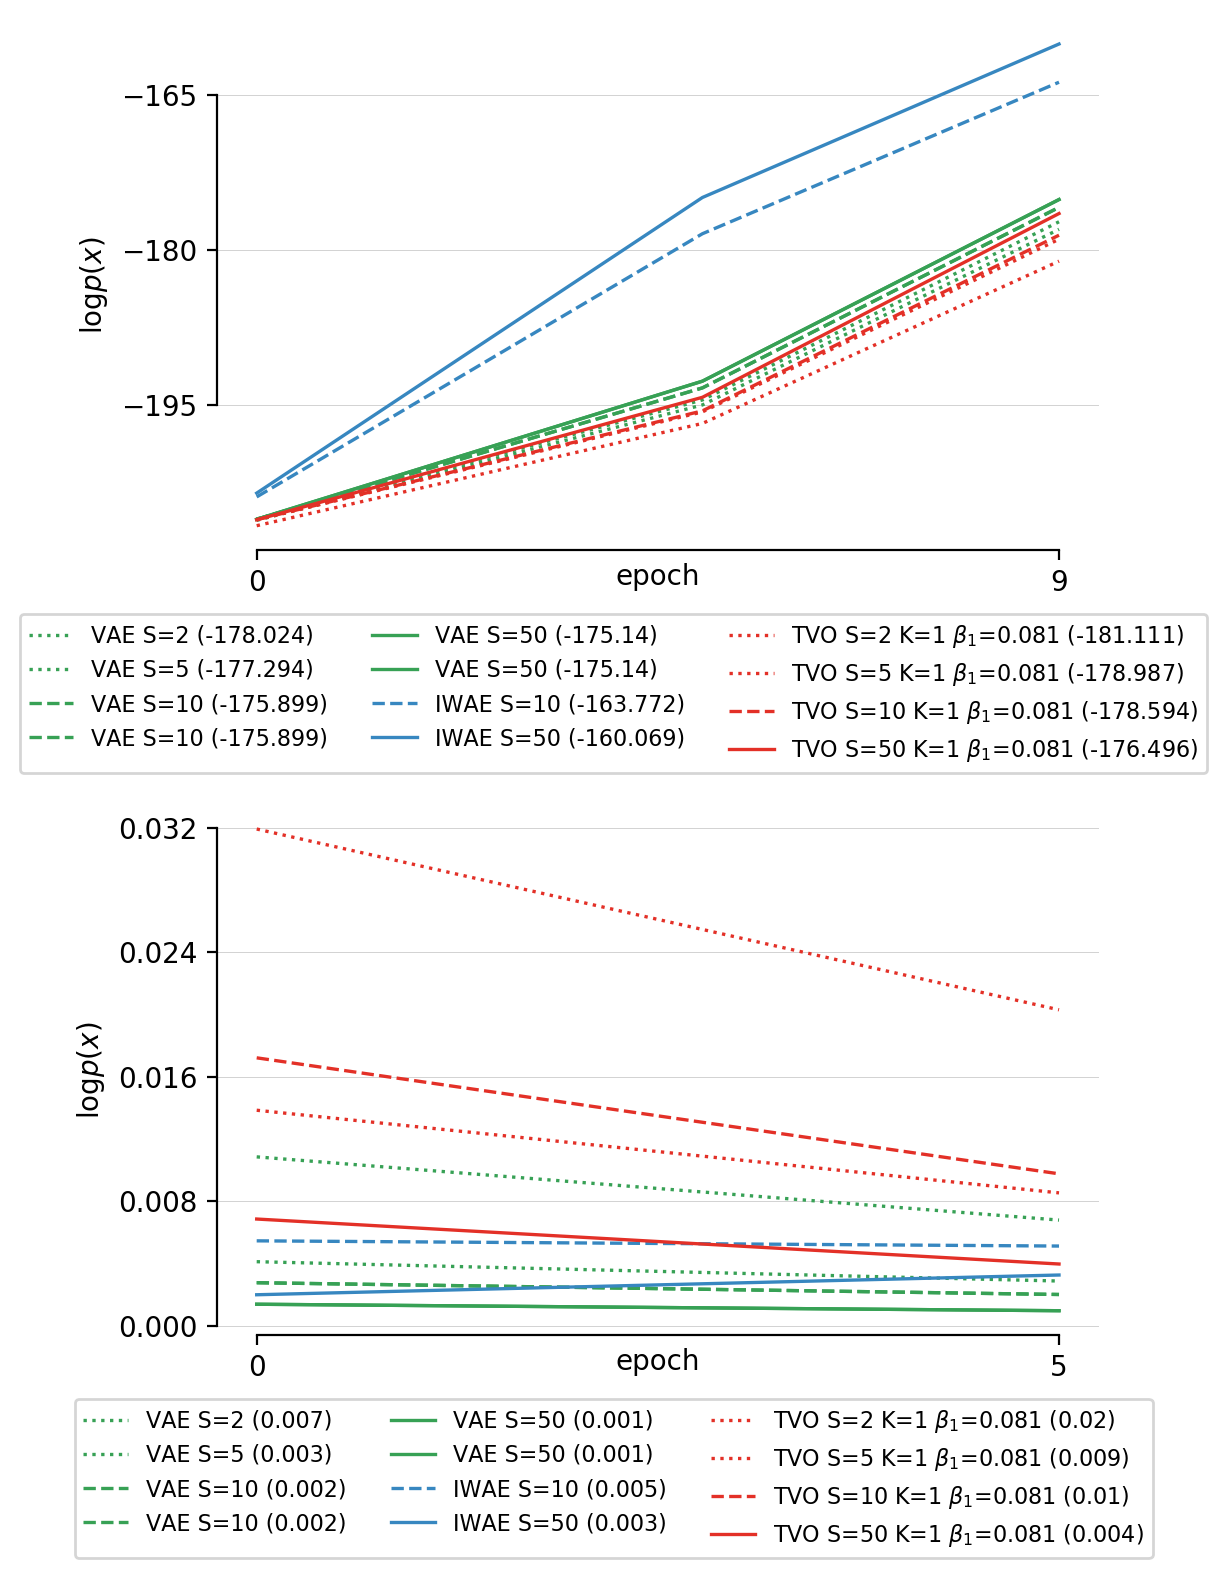

In [95]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=200, figsize=(6, 8))

linestyle = {
    2:":",
    5:":",
    10:"--",
    50:"solid",
}

colors = {
    "thermo":sns.color_palette('Reds_d', 1)[0],
    "vae":sns.color_palette('Greens_d', 1)[0],
    "iwae":sns.color_palette('Blues_d', 1)[0],
}


for loss in ['vae', 'iwae', 'thermo']:
    selection = exps.query('loss == @loss')
    if selection.shape[0] == 0:
        print("No runs for {}".format(loss))
        continue
    for index, row in selection.sort_values(["S"]).iterrows():
        S, K, log_beta_min = row["S"], row["K"], row["log_beta_min"]
        
        values = row['test.elbo']['values']
        values  = smooth(values, 20)
        
        if loss == 'thermo':
            label = r'{} S={} K={} $\beta_1$={} ({})'.format('TVO', S, K, round(10**log_beta_min, 3), round(values[-1], 3))
        else:
            label = r'{} S={} ({})'.format(loss.upper(), S, round(values[-1], 3))
                
        ax1.plot(row['test.elbo']['steps'],
                 values,
                 color = colors[loss],
                 linestyle = linestyle[S],
                 linewidth = 1.2,
                 label = label)
                    
        
        values = row['grad.variance']['values']
        values  = smooth(values, 20)
        
        if loss == 'thermo':
            label = r'{} S={} K={} $\beta_1$={} ({})'.format('TVO', S, K, round(10**log_beta_min, 3), round(values[-1], 3))
        else:
            label = r'{} S={} ({})'.format(loss.upper(), S, round(values[-1], 3))
                
        ax2.plot(row['grad.variance']['steps'],
                 values,
                 color = colors[loss],
                 linestyle = linestyle[S],
                 linewidth = 1.2,
                 label = label)
                    
        
# ax1.set_ylim(-92, -84)
ax1.grid(True, axis='y', linewidth=0.2)
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
leg = ax1.legend(fontsize=8, ncol=3, bbox_to_anchor=(0.45, -0.1), loc='upper center')

ax1.set_ylabel(r'$\log p(x)$')
ax1.set_xlabel('epoch')
ax1.xaxis.set_label_coords(0.5, -0.025)

# use last row arbitrarily
xmax = row['test.elbo']['steps'][-1]

ax1.set_xticks([0, xmax])
ax1.set_xticklabels([0, str(xmax)])
sns.despine(ax=ax1, trim=True)

ax2.grid(True, axis='y', linewidth=0.2)
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
leg = ax2.legend(fontsize=8, ncol=3, bbox_to_anchor=(0.45, -0.1), loc='upper center')

ax2.set_ylabel(r'$\log p(x)$')
ax2.set_xlabel('epoch')
ax2.xaxis.set_label_coords(0.5, -0.025)

xmax = row['grad.variance']['steps'][-1]

ax2.set_xticks([0, xmax])
ax2.set_xticklabels([0, str(xmax)])
sns.despine(ax=ax2, trim=True)

fig.tight_layout()


In [69]:
# Figure 7

No runs for reparam
No runs for cov


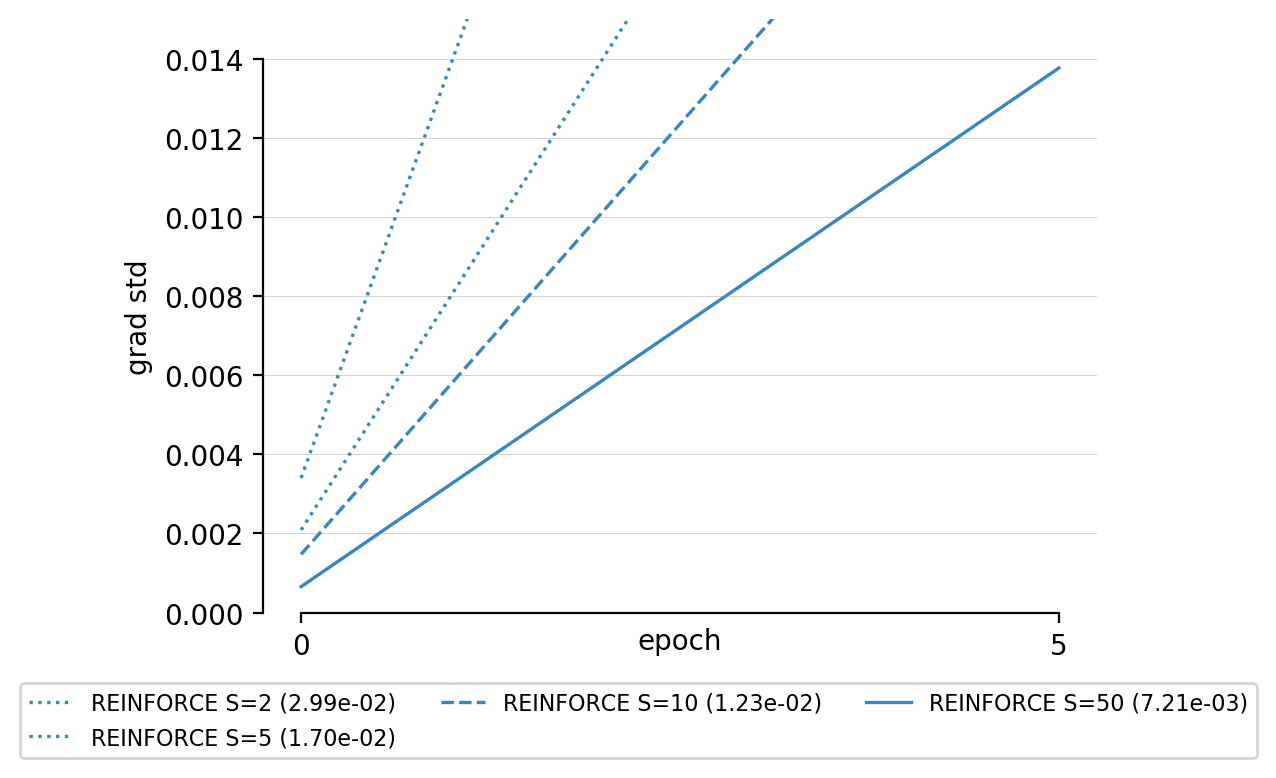

In [98]:
fig, ax1 = plt.subplots(1, 1, dpi=200, figsize=(6, 4))

linestyle = {
    2:":",
    5:":",
    10:"--",
    50:"solid",
}

colors = {
    "cov":sns.color_palette('Reds_d', 1)[0],
    "reparam":sns.color_palette('Greens_d', 1)[0],
    "reinforce":sns.color_palette('Blues_d', 1)[0],
}

for loss in ['reinforce', 'reparam', 'cov']:
    selection = exps.query('loss == @loss')
    if selection.shape[0] == 0:
        print("No runs for {}".format(loss))
        continue
    for index, row in selection.sort_values(["S"]).iterrows():
        method, S = row['loss'], row['S']
        grad_variance = row['grad.variance']['values']
        steps = row['grad.variance']['steps']

        grad_variance = smooth(grad_variance, 20)

        val = '%.2e' % Decimal(np.array(grad_variance).mean())
        label = r'{} S={} ({})'.format(method.upper(), S, val, 5)

        
        ax1.plot(steps,
                 grad_variance,
                 color = colors[loss],
                 linestyle = linestyle[S],
                 linewidth = 1.2,
                 label = label)


ax1.set_ylim(0, 0.015)
ax1.grid(True, axis='y', linewidth=0.2)

leg = ax1.legend(fontsize=8, ncol=3, bbox_to_anchor=(0.45, -0.1), loc='upper center')

# use last row arbitrarily
xmax = row['grad.variance']['steps'][-1]

ax1.set_ylabel(r"grad std")
ax1.set_xlabel('epoch')
ax1.xaxis.set_label_coords(0.5, -0.025)
ax1.set_xticks([0, xmax])
ax1.set_xticklabels([0, str(xmax)])
sns.despine(ax=ax1, trim=True)
fig.tight_layout()
plt.show()